In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory
from pprint import pprint
import spacy
import numpy as np

c:\Users\aiden\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
class Config:
    SEED: int = 42
    # SAMPLE = None
    SAMPLE: int = 10000
    BASE_DATA_PATH: str = '../data/'
    BASE_OUTPUT_PATH: str = '../output/'

In [3]:
file_path = f'{Config.BASE_DATA_PATH}/arXiv_scientific dataset.csv'

raw_df = pd.read_csv(file_path)

In [4]:
raw_df.describe()

,summary_word_count
count,136238.000000
mean,162.386830
std,49.374474
min,1.000000
25%,128.000000
50%,160.000000
75%,195.000000
max,552.000000


In [5]:
raw_df.head()

,id,title,category,category_code,published_date,updated_date,authors,first_author,summary,summary_word_count
0,cs-9308101v1,Dynamic Backtracking,Artificial Intelligence,cs.AI,8/1/93,8/1/93,['M. L. Ginsberg'],'M. L. Ginsberg',Because of their occasional need to return to ...,79
1,cs-9308102v1,A Market-Oriented Programming Environment and ...,Artificial Intelligence,cs.AI,8/1/93,8/1/93,['M. P. Wellman'],'M. P. Wellman',Market price systems constitute a well-underst...,119
2,cs-9309101v1,An Empirical Analysis of Search in GSAT,Artificial Intelligence,cs.AI,9/1/93,9/1/93,"['I. P. Gent', 'T. Walsh']",'I. P. Gent',We describe an extensive study of search in GS...,167
3,cs-9311101v1,The Difficulties of Learning Logic Programs wi...,Artificial Intelligence,cs.AI,11/1/93,11/1/93,"['F. Bergadano', 'D. Gunetti', 'U. Trinchero']",'F. Bergadano',As real logic programmers normally use cut (!)...,174
4,cs-9311102v1,Software Agents: Completing Patterns and Const...,Artificial Intelligence,cs.AI,11/1/93,11/1/93,"['J. C. Schlimmer', 'L. A. Hermens']",'J. C. Schlimmer',To support the goal of allowing users to recor...,187


In [6]:
raw_df['category'].value_counts()

category
Machine Learning                                          39986
Computer Vision and Pattern Recognition                   29057
Computation and Language (Natural Language Processing)    25202
Artificial Intelligence                                   12969
Machine Learning (Statistics)                             10447
                                                          ...  
Nuclear Experiment                                            1
Superconductivity                                             1
Pattern Formation and Solitons                                1
General Mathematics                                           1
History and Philosophy of Physics                             1
Name: count, Length: 138, dtype: int64

In [7]:
raw_df['summary'][10]

'We report on a series of experiments in which all decision trees consistent\nwith the training data are constructed. These experiments were run to gain an\nunderstanding of the properties of the set of consistent decision trees and the\nfactors that affect the accuracy of individual trees. In particular, we\ninvestigated the relationship between the size of a decision tree consistent\nwith some training data and the accuracy of the tree on test data. The\nexperiments were performed on a massively parallel Maspar computer. The results\nof the experiments on several artificial and two real world problems indicate\nthat, for many of the problems investigated, smaller consistent decision trees\nare on average less accurate than the average accuracy of slightly larger\ntrees.'

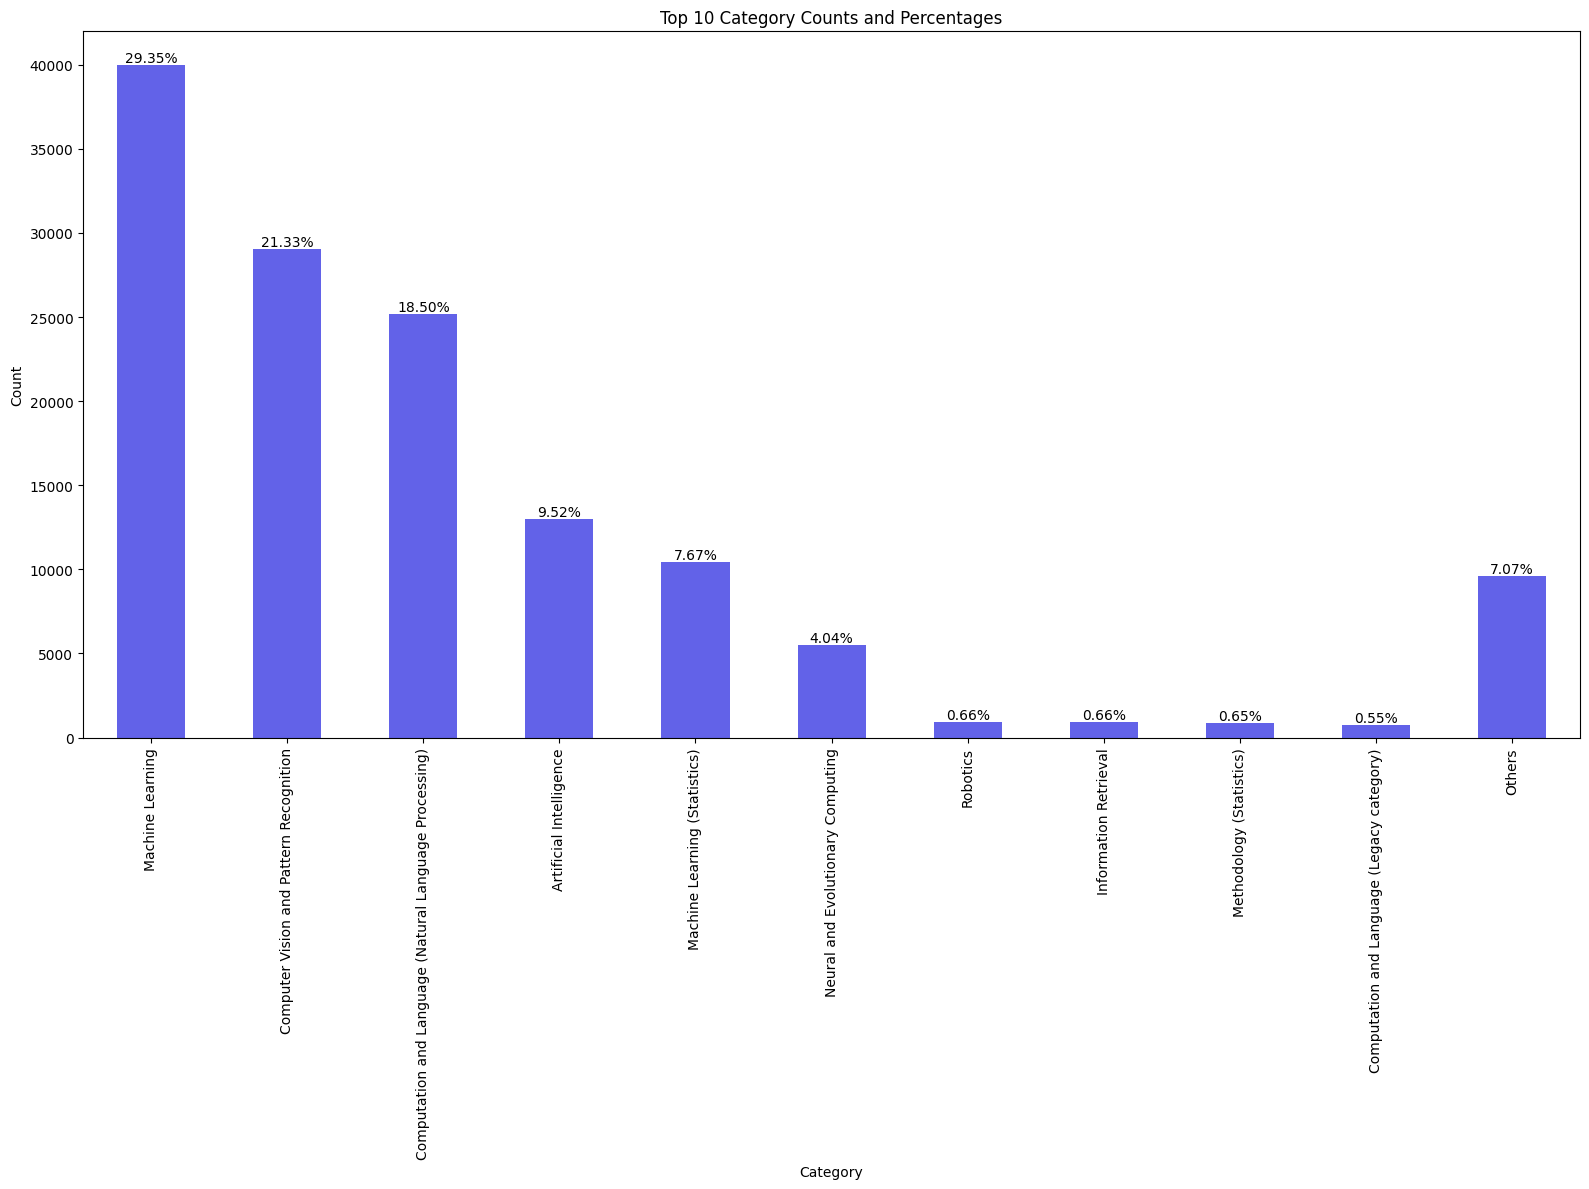

In [8]:
# Calculate the counts of the categories
category_counts = raw_df['category'].value_counts()

# Select the top 10 categories and group the rest into 'Others'
top_categories = category_counts.head(10)
other_categories = category_counts.iloc[10:].sum()


# Create a new category that includes 'Others'
category_counts_modified = pd.concat([top_categories, pd.Series({'Others': other_categories})])
# Calculate the percentages
category_percentages = category_counts_modified / category_counts_modified.sum() * 100

# Combine counts and percentages into a DataFrame
category_df = pd.DataFrame({
    'count': category_counts_modified,
    'percentage': category_percentages
}).reset_index()
category_df.columns = ['category', 'count', 'percentage']

# Create a Seaborn bar plot
plt.figure(figsize=(16, 12))
sns.barplot(x='category', y='count', data=category_df, color='blue', alpha=0.7, width=0.5)

# Annotate percentages on top of bars
for i in range(len(category_df)):
    plt.text(i, category_df['count'].iloc[i] + 0.5, f'{category_df["percentage"].iloc[i]:.2f}%', 
             ha='center', va='bottom', fontsize=10)

plt.title('Top 10 Category Counts and Percentages')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [9]:
if Config.SAMPLE is not None:
    df = raw_df.sample(Config.SAMPLE, random_state=Config.SEED)
    del raw_df
else:
    df = raw_df

In [10]:
df.isnull().values.any()

False

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 78358 to 58556
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  10000 non-null  object
 1   title               10000 non-null  object
 2   category            10000 non-null  object
 3   category_code       10000 non-null  object
 4   published_date      10000 non-null  object
 5   updated_date        10000 non-null  object
 6   authors             10000 non-null  object
 7   first_author        10000 non-null  object
 8   summary             10000 non-null  object
 9   summary_word_count  10000 non-null  int64 
dtypes: int64(1), object(9)
memory usage: 859.4+ KB


In [12]:
DetectorFactory.seed = Config.SEED

languages = []

# go through each text
for ii in tqdm(range(0,len(df))):
    # split by space into list, take the first x intex, join with space
    text = df.iloc[ii]['summary'].split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    # ught... beginning of the document was not in a good format
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        # what!! :( let's see if we can find any text in abstract...
        except Exception as e:
            
            try:
                # let's try to label it through the abstract then
                lang = detect(df.iloc[ii]['abstract_summary'])
            except Exception as e:
                lang = "unknown"
                pass
    
    # get the language    
    languages.append(lang)

100%|██████████| 10000/10000 [01:01<00:00, 161.98it/s]


In [13]:
languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)
    
print("Total: {}\n".format(len(languages)))
pprint(languages_dict)

Total: 10000

{'en': 10000}


In [14]:
print(f'In summary, there are {languages_dict}')

In summary, there are {'en': 10000}


C:\Users\aiden\AppData\Local\Temp\ipykernel_18564\1963173411.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  published_date = pd.to_datetime(df['published_date'])


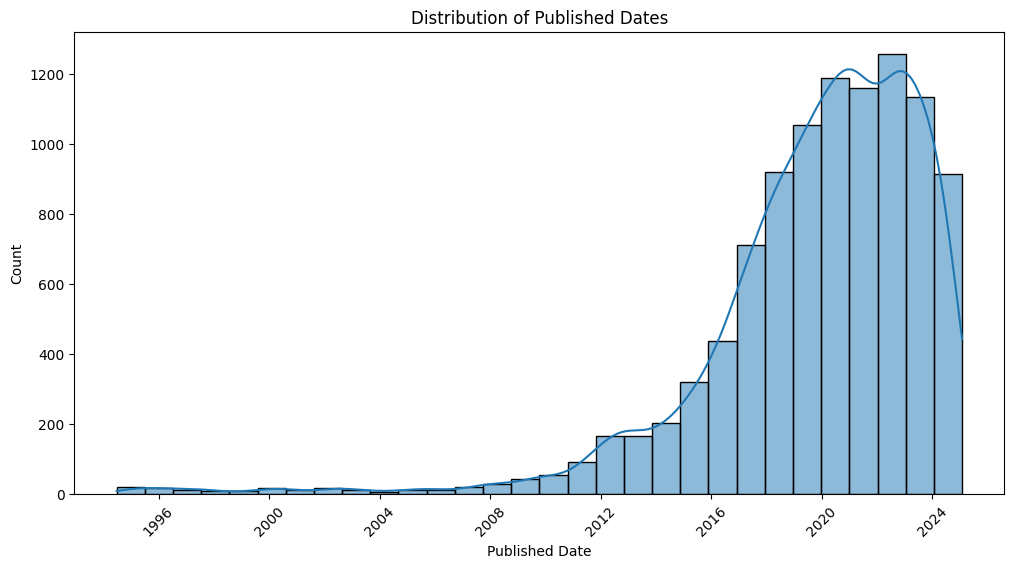

In [15]:
published_date = pd.to_datetime(df['published_date'])

plt.figure(figsize=(12, 6))
sns.histplot(published_date, bins=30, kde=True)  # Adjust bins as needed
plt.xticks(rotation=45)
plt.xlabel("Published Date")
plt.ylabel("Count")
plt.title("Distribution of Published Dates")
plt.show()

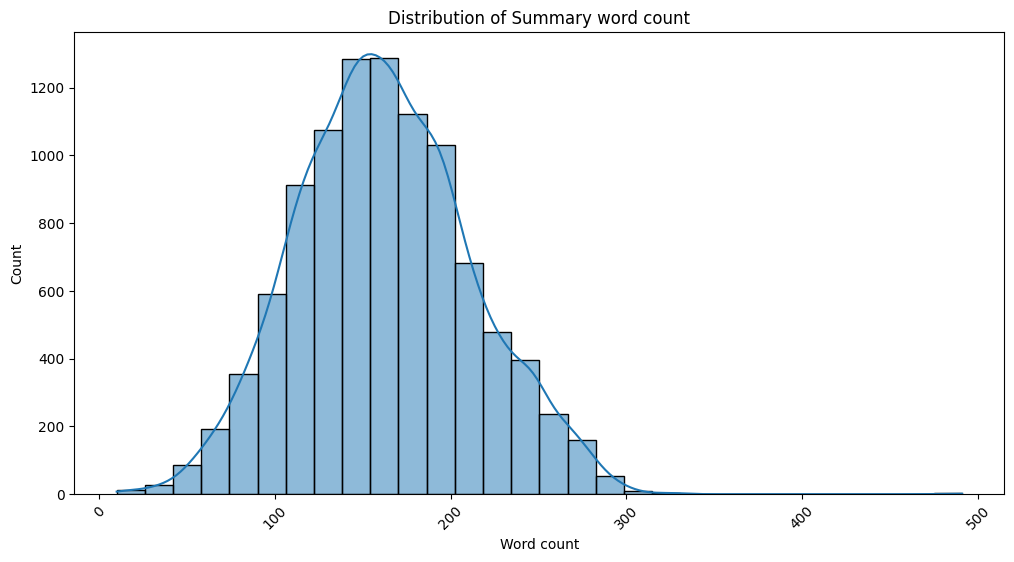

In [16]:
plt.figure(figsize=(12, 6))
sns.histplot(df['summary_word_count'], bins=30, kde=True)  # Adjust bins as needed
plt.xticks(rotation=45)
plt.xlabel("Word count")
plt.ylabel("Count")
plt.title("Distribution of Summary word count")
plt.show()

In [17]:
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm

stopwords = list(STOP_WORDS)
print(f'{len(stopwords)=}')
print(f'{stopwords[:10]=}')
punctuations = string.punctuation

len(stopwords)=326
stopwords[:10]=['alone', 'me', '’m', 'many', 'six', 'call', 'about', 'both', 'put', 'whereupon']


c:\Users\aiden\AppData\Local\Programs\Python\Python310\lib\site-packages\spacy\util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.5.0) was trained with spaCy v3.5.0 and may not be 100% compatible with the current version (3.8.5). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [18]:
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI'
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)

In [19]:
parser = en_core_web_sm.load(disable=["tagger", "ner"])
parser.max_length = 7000000

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens


In [20]:
parser = en_core_web_sm.load(disable=["tagger", "ner"])
parser.max_length = 7000000

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [21]:
df.head()

,id,title,category,category_code,published_date,updated_date,authors,first_author,summary,summary_word_count
78358,abs-1704.04688v1,Machine Learning and the Future of Realism,Machine Learning (Statistics),stat.ML,4/15/17,4/15/17,"['Giles Hooker', 'Cliff Hooker']",'Giles Hooker',The preceding three decades have seen the emer...,106
37291,abs-2405.16697v1,CNN Autoencoder Resizer: A Power-Efficient LoS...,Machine Learning,cs.LG,5/26/24,5/26/24,"['Azim Akhtarshenas', 'Navid Ayoobi', 'David L...",'Azim Akhtarshenas',"Optimizing the design, performance, and resour...",143
132977,abs-2109.03754v2,Memory and Knowledge Augmented Language Models...,Computation and Language (Natural Language Pro...,cs.CL,9/8/21,9/14/21,"['David Wilmot', 'Frank Keller']",'David Wilmot',Measuring event salience is essential in the u...,115
69011,abs-2102.07318v4,A Global to Local Double Embedding Method for ...,Computer Vision and Pattern Recognition,cs.CV,2/15/21,10/17/21,"['Yiming Xu', 'Jiaxin Li', 'Yiheng Peng', 'Yan...",'Yiming Xu',Multi-person pose estimation is a fundamental ...,212
57403,abs-1812.05788v2,AU R-CNN: Encoding Expert Prior Knowledge into...,Computer Vision and Pattern Recognition,cs.CV,12/14/18,8/25/19,"['Chen Ma', 'Li Chen', 'Junhai Yong']",'Chen Ma',Detecting action units (AUs) on human faces is...,245


In [22]:
tqdm.pandas()
df["processed_text"] = df["summary"].progress_apply(spacy_tokenizer)

  0%|          | 0/10000 [00:00<?, ?it/s]c:\Users\aiden\AppData\Local\Programs\Python\Python310\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
100%|██████████| 10000/10000 [5:46:01<00:00,  2.08s/it]      


In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorize(text1, max_features):
    vectorizer = TfidfVectorizer(max_features=max_features)
    return vectorizer.fit_transform(text1)

In [24]:
text = df['processed_text'].values
X = vectorize(text, 2 ** 12)
X.shape

(10000, 4096)

In [25]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(10000, 2830)

In [26]:
X_reduced[0]

array([-0.04737954, -0.03907844, -0.00435648, ..., -0.00206124,
        0.00594754,  0.01738689])

In [27]:
print(f'Reduced dimensions from {X.shape} to {X_reduced.shape}')

Reduced dimensions from (10000, 4096) to (10000, 2830)


## Clustering

In [28]:
from sklearn.cluster import KMeans

from sklearn import metrics
from scipy.spatial.distance import cdist

# run kmeans with many different k
distortions = []
K = range(5, 30)
for k in K:
    # k_means = KMeans(n_clusters=k, random_state=42, n_jobs=-1).fit(X_reduced) #TODO no n_jobs param
    k_means = KMeans(n_clusters=k, random_state=Config.SEED).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

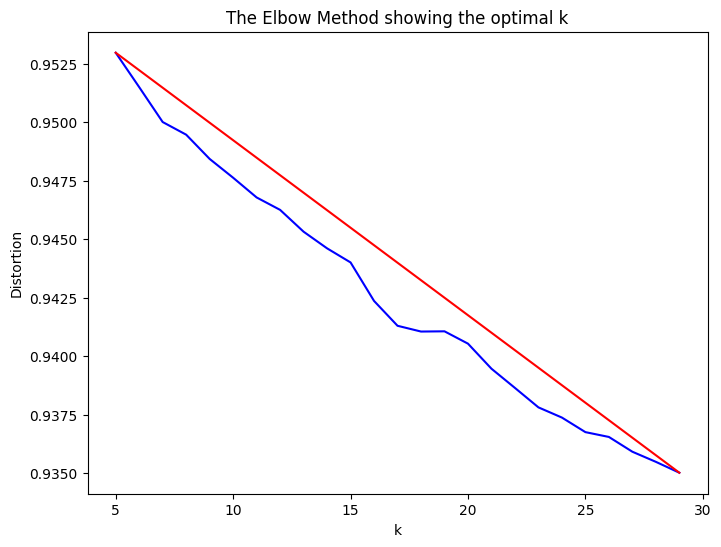

In [29]:
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.figure(figsize=(8, 6))
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [30]:
k = 20
kmeans = KMeans(n_clusters=k, random_state=Config.SEED)
y_pred = kmeans.fit_predict(X_reduced)
df['cluster_id'] = y_pred

In [31]:
# %matplotlib inline
# from matplotlib import pyplot as plt
# import seaborn as sns
# 
# # sns settings
# sns.set(rc={'figure.figsize':(15, 15)})
# 
# # colors
# palette = sns.hls_palette(20, l=.4, s=.9)
# 
# # plot
# sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
# plt.title('t-SNE with Kmeans Labels')
# plt.show()

In [32]:
df.head(10)

,id,title,category,category_code,published_date,updated_date,authors,first_author,summary,summary_word_count,processed_text,cluster_id
78358,abs-1704.04688v1,Machine Learning and the Future of Realism,Machine Learning (Statistics),stat.ML,4/15/17,4/15/17,"['Giles Hooker', 'Cliff Hooker']",'Giles Hooker',The preceding three decades have seen the emer...,106,preceding decades seen emergence rise prolifer...,1
37291,abs-2405.16697v1,CNN Autoencoder Resizer: A Power-Efficient LoS...,Machine Learning,cs.LG,5/26/24,5/26/24,"['Azim Akhtarshenas', 'Navid Ayoobi', 'David L...",'Azim Akhtarshenas',"Optimizing the design, performance, and resour...",143,optimizing design performance resource efficie...,1
132977,abs-2109.03754v2,Memory and Knowledge Augmented Language Models...,Computation and Language (Natural Language Pro...,cs.CL,9/8/21,9/14/21,"['David Wilmot', 'Frank Keller']",'David Wilmot',Measuring event salience is essential in the u...,115,measuring event salience essential understandi...,13
69011,abs-2102.07318v4,A Global to Local Double Embedding Method for ...,Computer Vision and Pattern Recognition,cs.CV,2/15/21,10/17/21,"['Yiming Xu', 'Jiaxin Li', 'Yiheng Peng', 'Yan...",'Yiming Xu',Multi-person pose estimation is a fundamental ...,212,multi person pose estimation fundamental chall...,15
57403,abs-1812.05788v2,AU R-CNN: Encoding Expert Prior Knowledge into...,Computer Vision and Pattern Recognition,cs.CV,12/14/18,8/25/19,"['Chen Ma', 'Li Chen', 'Junhai Yong']",'Chen Ma',Detecting action units (AUs) on human faces is...,245,detecting action units aus human faces challen...,15
59143,abs-1803.03396v2,Cross-View Image Synthesis using Conditional GANs,Computer Vision and Pattern Recognition,cs.CV,3/9/18,3/29/18,"['Krishna Regmi', 'Ali Borji']",'Krishna Regmi',Learning to generate natural scenes has always...,243,learning generate natural scenes challenging t...,14
83077,abs-2006.13666v2,Uncertainty in Neural Relational Inference Tra...,Machine Learning,cs.LG,6/24/20,6/25/20,"['Vasileios Karavias', 'Ben Day', 'Pietro Liò']",'Vasileios Karavias',Neural networks used for multi-interaction tra...,117,neural networks multi interaction trajectory r...,6
117818,abs-1811.03729v1,Incorporating Relevant Knowledge in Context Mo...,Computation and Language (Natural Language Pro...,cs.CL,11/9/18,11/9/18,"['Yanran Li', 'Wenjie Li', 'Ziqiang Cao', 'Che...",'Yanran Li',"To sustain engaging conversation, it is critic...",103,sustain engaging conversation critical chatbot...,7
21567,abs-2310.06075v1,Pain Forecasting using Self-supervised Learnin...,Artificial Intelligence,cs.AI,10/9/23,10/9/23,"['Swati Padhee', 'Tanvi Banerjee', 'Daniel M. ...",'Swati Padhee',Sickle Cell Disease (SCD) is a chronic genetic...,226,sickle cell disease scd chronic genetic disord...,1
63453,abs-2012.04641v2,Vid2CAD: CAD Model Alignment using Multi-View ...,Computer Vision and Pattern Recognition,cs.CV,12/8/20,1/25/22,"['Kevis-Kokitsi Maninis', 'Stefan Popov', 'Mat...",'Kevis-Kokitsi Maninis',We address the task of aligning CAD models to ...,154,address task aligning cad models video sequenc...,15


In [33]:
df.to_csv(f'{Config.BASE_OUTPUT_PATH}/cluster_sample_10000_v2.csv')


### Dimensionality Reduction with t-SNE

In [34]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=100, random_state=Config.SEED)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.059s...
[t-SNE] Computed neighbors for 10000 samples in 3.709s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.302268
[t-SNE] KL divergence after 50 iterations with early exaggeration: 83.055855
[t-SNE] KL divergence after 1000 iterations: 2.678757


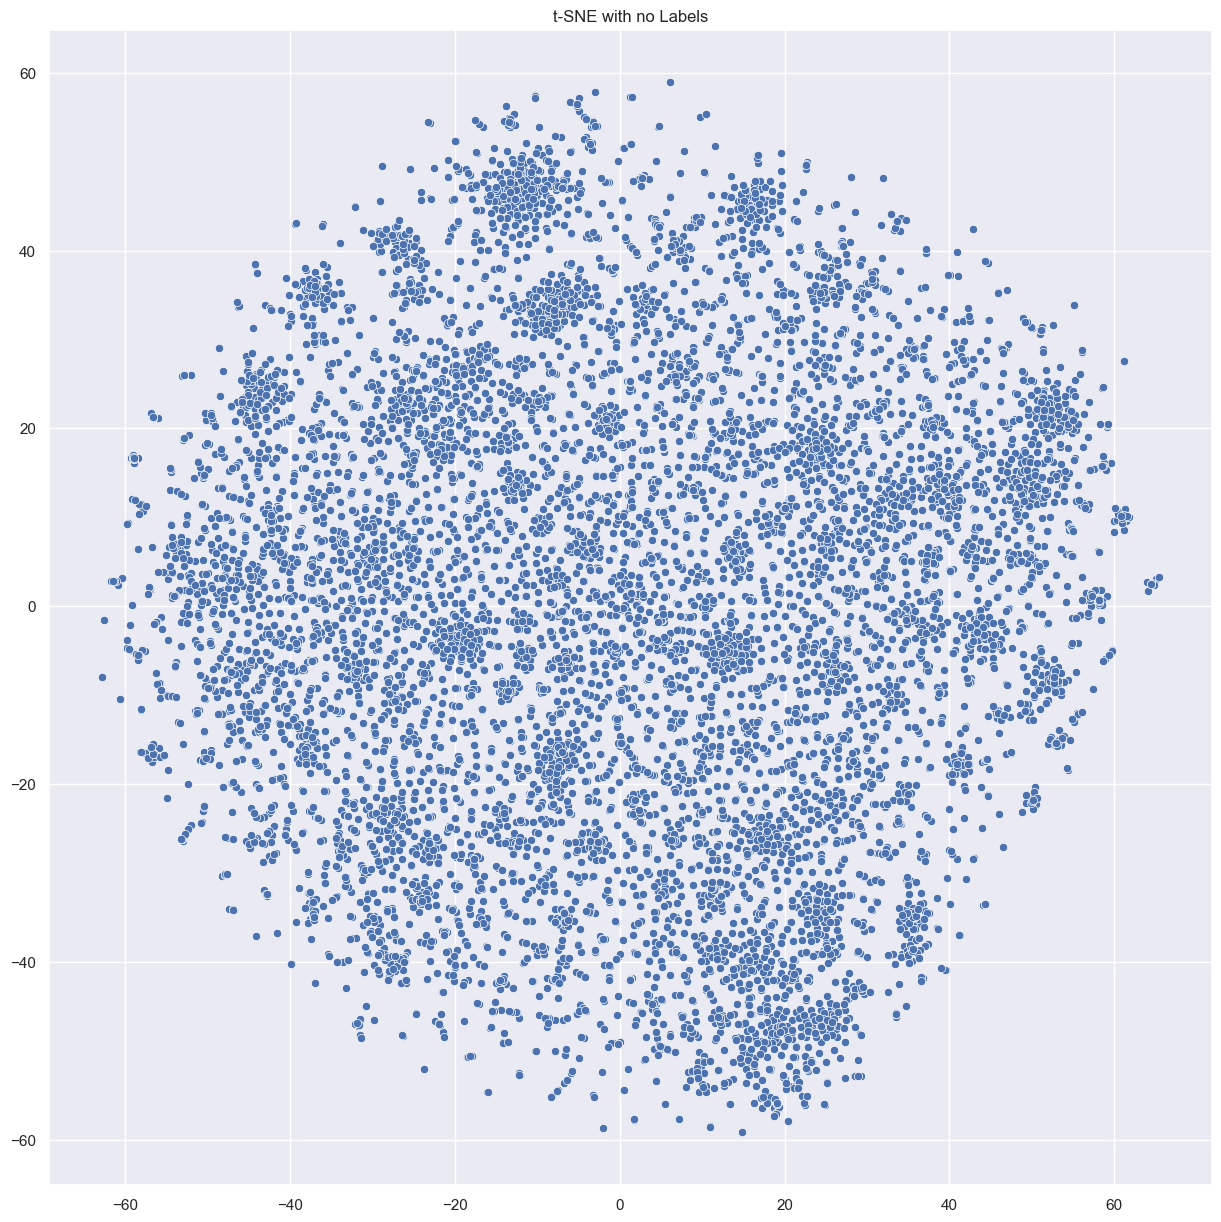

In [35]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# plot
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1])
plt.title('t-SNE with no Labels')
plt.show()

In [36]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

vectorizers = []
    
for ii in range(0, 20):
    # Creating a vectorizer
    vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))

In [37]:
vectorizers[0]

CountVectorizer(max_df=0.9, min_df=5, stop_words='english',
                token_pattern='[a-zA-Z\\-][a-zA-Z\\-]{2,}')

In [38]:
vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(df.loc[df['cluster_id'] == current_cluster, 'processed_text']))
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)

In [39]:
len(vectorized_data)

20

In [40]:
NUM_TOPICS_PER_CLUSTER = 20

lda_models = []
for ii in range(0, 20):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)
    
lda_models[0]

LatentDirichletAllocation(learning_method='online', n_components=20,
                          random_state=42, verbose=False)

In [41]:
clusters_lda_data = []

for current_cluster, lda in tqdm(enumerate(lda_models)):
    if vectorized_data[current_cluster] is not None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))

20it [00:42,  2.11s/it]


In [42]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names_out()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for keyword in keywords:
        return_values.append(keyword[0])
    return return_values

In [43]:
all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] is not None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

In [44]:
# all_keywords[0][:10]

In [45]:
exclude = {"model", "models", "training", "data", "learning"}

for i, kws in enumerate(all_keywords):
    # remove any “model”/“models” (case‐insensitive)
    filtered = [kw for kw in kws if kw.lower() not in exclude]
    # take the first 8 of the filtered list
    top8 = filtered[:8]
    print(f"Cluster {i}: {top8}")

Cluster 0: ['nmt', 'machine', 'based', 'languages', 'semantic', 'input', 'level', 'document']
Cluster 1: ['information', 'based', 'time', 'attention', 'research', 'temporal', 'human', 'series']
Cluster 2: ['agent', 'tasks', 'policy', 'based', 'offline', 'gradient', 'feedback', 'language']
Cluster 3: ['tasks', 'reasoning', 'knowledge', 'performance', 'health', 'clinical', 'datasets', 'long']
Cluster 4: ['time', 'methods', 'detection', 'ood', 'classes', 'anomaly', 'samples', 'active']
Cluster 5: ['pruning', 'quantization', 'hardware', 'memory', 'neural', 'networks', 'cnn', 'net']
Cluster 6: ['causal', 'matrix', 'based', 'regression', 'time', 'bounds', 'error', 'bound']
Cluster 7: ['relations', 'student', 'relation', 'extraction', 'ner', 'entities', 'entity', 'named']
Cluster 8: ['target', 'source', 'adaptation', 'domains', 'real', 'shot', 'distribution', 'dataset']
Cluster 9: ['optimization', 'search', 'regret', 'algorithms', 'gradient', 'bandit', 'multi', 'bound']
Cluster 10: ['cluster'

In [46]:
import pickle

# save the final t-SNE
pickle.dump(X_embedded, open(f"{Config.BASE_OUTPUT_PATH}/X_embedded_all.p", "wb" ))

# save the labels generate with k-means(20)
pickle.dump(y_pred, open(f"{Config.BASE_OUTPUT_PATH}/y_pred_all.p", "wb" ))

# save the model too
with open(f'{Config.BASE_OUTPUT_PATH}/kmeans_model_all.pkl', 'wb') as f:
    pickle.dump(kmeans, f)

In [47]:
df_research = df
topics = all_keywords
y_labels = y_pred

In [48]:
df_research['cluster_id'] = y_pred
df_research['x'] = X_embedded[:,0]
df_research['y'] = X_embedded[:,1]

In [49]:
# df_research.drop('y', axis=1, inplace=True)
# df_research.head(3)
df_research.to_csv(f'{Config.BASE_OUTPUT_PATH}/df_research_clustered_10000_xy.csv', index=False)

In [50]:
import json

data = [
    {"cluster_id": i+1, "keywords": kws}
    for i, kws in enumerate(all_keywords)
]

# save
with open(f'{Config.BASE_OUTPUT_PATH}/keywords.json', 'w', encoding='utf-8') as f:
    json.dump(data, f, ensure_ascii=False, indent=2)
# --- load later ---
# with open('keywords.json', 'r', encoding='utf-8') as f:
#     all_keywords = json.load(f)    

In [51]:
df_research.head(2)
# from plot_text import header, description, description2, cite, description_search, description_slider, notes, dataset_description, toolbox_header 
# from callbacks import input_callback, selected_code
import bokeh
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, CustomJS, Slider, TapTool, TextInput
from bokeh.palettes import Category20
from bokeh.transform import linear_cmap, transform
from bokeh.io import output_file, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import RadioButtonGroup, TextInput, Div, Paragraph
from bokeh.layouts import column, row, layout
from bokeh.layouts import column

In [52]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource

output_notebook()

hover = HoverTool(tooltips=[
    ("Title", "@titles{safe}"),
    ("Author(s)", "@authors{safe}"),
    # ("Journal", "@journal"),
    # ("Abstract", "@abstract{safe}"),
    # ("Link", "@links")
],
point_policy="follow_mouse")

mapper = linear_cmap(field_name='desc', 
                     palette=Category20[20],
                     low=min(y_labels) ,high=max(y_labels))

source = ColumnDataSource(data=dict(
    x= X_embedded[:,0], 
    y= X_embedded[:,1],
    x_backup = X_embedded[:,0],
    y_backup = X_embedded[:,1],
    desc= y_labels, 
    titles= df_research['title'],
    authors = df_research['authors'],
    labels = ["C-" + str(x) for x in y_labels],
    ))

p = figure(
    width=1200, height=850, 
    background_fill_color="white",   # the inside of the plot
    tools=[hover, 'pan', 'wheel_zoom', 'box_zoom', 'reset', 'save', 'tap'], 
    title="AI Research clustering")
p.sizing_mode = "scale_both"
p.margin = 5

p.scatter('x','y', 
          source=source, 
          fill_color=mapper,
          line_alpha=0.3,
          line_color="black",
          size=5)
show(p)

Loading BokehJS ...